In [2]:
%run /work/jupyter_notebooks/index_hgt/base_functions.ipynb
%cd /work/index_hgt/

/work/index_hgt


In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import subprocess

plotly_accession = open('/Users/thiberio/plotly_accession').read().split()
ptl.sign_in(plotly_accession[0], plotly_accession[1])

In [ ]:
if not os.path.isdir('reconciliation_aggregates'):
    os.mkdir('reconciliation_aggregates')
for folder in os.listdir('ranger/'):
    if os.path.isfile('reconciliation_aggregates/%s' % folder):
        continue
    os.system('cp ranger/%s/aggregated reconciliation_aggregates/%s' % (folder, folder))

In [ ]:
if not os.path.isdir('renamed_gene_tree'):
    os.mkdir('renamed_gene_tree')

for treefile in os.listdir('gene_trees/'):
    if not treefile.endswith('.treefile'):
        continue
    if os.path.isfile('renamed_gene_tree/%s' % treefile):
        continue
    
    tmp_tree = ete3.Tree('gene_trees/%s' % treefile)
    for leaf in tmp_tree.get_leaves():
        if leaf.name.count('_') == 1:
            gene, genome = leaf.name.split('_')
        elif leaf.name.count('_') > 1 and re.search('GC[AF]_', leaf.name):
            gene, genome = re.search('^([^.]+).+?(GC[AF]_\d+)', leaf.name, re.M).groups()
        elif leaf.name.count('_') == 2 and re.search('_PRJ', leaf.name):
            gene, genome = re.search('^(.+)_(PRJ.+)$', leaf.name, re.M).groups()
        else:
            print(leaf.name)
        gene = gene.split('.')[0]
        leaf.name = '%s_%s' % (genome.replace('_', ''), gene.replace('_', ''))
    
    tmp_tree.write(outfile='renamed_gene_tree/%s' % treefile, format=0, dist_formatter='%.10f')

In [135]:
ranger_parser = aggregate(reference_tree='species_tree-renamed',
                          gene_tree_folder='renamed_gene_tree/',
                          aggregate_folder='reconciliation_aggregates/',
                          reconciliation_folder='ranger/',
                          overall_tree_support_thresh=20,
                          leaves_allowed=False)

In [4]:
if not os.path.isfile('transfers.tab'):
    transfers = []
    for count, group in enumerate(os.listdir('ranger')):
        if not os.path.getsize('ranger/%s/%s.output1' % (group, group)):
            continue
        transfers.append(ranger_parser.parse_aggregated(group))

    transfer_df = pd.concat([n[0] for n in transfers 
                             if type(n) is not dict], ignore_index=True, axis=0, sort=False)
    transfer_df.loc[:,['ranger_confidence',
                       'ranger_confidence_donor',
                       'ranger_confidence_recipient']] = transfer_df.loc[:,['ranger_confidence',
                                                                            'ranger_confidence_donor',
                                                                            'ranger_confidence_recipient']] / 50

    transfer_df.to_csv('transfers.tab', sep='\t')
else:
    transfer_df = pd.read_csv('transfers.tab', sep='\t', index_col=0)

In [ ]:
print(transfer_df.shape)
transfer_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(15,10), dpi=300)
colors   = sns.color_palette(n_colors=4).as_hex()
for row, column in enumerate(['bipartition_support', 
                              'ranger_confidence',
                              'ranger_confidence_donor',
                              'ranger_confidence_recipient']):
    sns.kdeplot(transfer_df[column],
                shade=True, color=colors[row], ax=axs[row])

In [5]:
transfer_df = transfer_df[(transfer_df.bipartition_support        >=95)  &
                          (transfer_df.ranger_confidence          >=0.8) &
                          (transfer_df.ranger_confidence_donor    >=0.8) &
                          (transfer_df.ranger_confidence_recipient>=0.8)]
print(transfer_df.shape)
transfer_df.head()

(815, 9)


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1
50,100.0,n153,m60,1.0,1.0,1.0,n158,m64,8868_BAB76993.1-GCA_000009705.1
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1
76,100.0,n155,m10,1.0,1.0,1.0,n8,m11,7453_BAB75578.1-GCA_000009705.1


In [179]:
ranger_parser.name_species_tree_nodes(
    reconciliation_file='ranger/4468_BAB72593.1-GCA_000009705.1/4468_BAB72593.1-GCA_000009705.1.output1'
)

In [ ]:
ranger_parser.species_tree.write(outfile='species_tree_named_nodes',
                               format=1,
                               dist_formatter='%.10f')

In [ ]:
out = open('maxtic.input', 'w')
for index, row in transfer_df[['donor', 'recipient']].iterrows():
    out.write('%s\n' % '\t'.join(row.tolist()))
out.close()

In [ ]:
subprocess.call(['python2.7',
                 '/work/ale/maxtic/MaxTiC.py',
                 'species_tree_named_nodes',
                 'maxtic.input',
                 'ls=180'])

In [7]:
donor_recipient_pairs = []
for line in open('maxtic.input_MT_output_partial_order').readlines():
    donor_recipient_pairs.append('-'.join(line.split()[:2]))

transfer_df['donor-recipient'] = transfer_df['donor']+'-'+transfer_df['recipient']
transfer_df = transfer_df[transfer_df['donor-recipient'].isin(donor_recipient_pairs)]
transfer_df.drop(labels='donor-recipient', axis=1, inplace=True)
transfer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 21 to 20461
Data columns (total 9 columns):
bipartition_support            624 non-null float64
donor                          624 non-null object
donor_map                      624 non-null object
ranger_confidence              624 non-null float64
ranger_confidence_donor        624 non-null float64
ranger_confidence_recipient    624 non-null float64
recipient                      624 non-null object
recipient_map                  624 non-null object
family                         624 non-null object
dtypes: float64(4), object(5)
memory usage: 48.8+ KB


In [124]:
extended_df = ranger_parser.assess_transfer_distance(transfer_df)
extended_df = ranger_parser.assess_dtl_cost(extended_df)

print(extended_df.shape)
extended_df.head()

(624, 17)


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio
21,100.0,n76,m75,1.0,1.0,1.0,n79,m76,4468_BAB72593.1-GCA_000009705.1,0.372650,13.0,2.0,15.0,2.0,6.500000,7.500000,0.500000
33,95.0,n101,m83,1.0,1.0,1.0,n105,m91,6335_BAB74460.1-GCA_000009705.1,0.217616,16.0,4.0,16.0,6.0,4.000000,2.666667,1.222222
70,100.0,n76,m7,1.0,1.0,1.0,n108,m8,5056_BAB73181.1-GCA_000009705.1,0.454789,13.0,2.0,19.0,2.0,6.500000,9.500000,0.750000
128,96.0,n165,m326,1.0,1.0,1.0,n168,m330,1446_AAM72707.1-GCA_000006985.1,0.096659,8.0,2.0,10.0,2.0,4.000000,5.000000,0.500000
151,99.0,n159,m11,1.0,1.0,1.0,n133,m12,8_AAM71256.1-GCA_000006985.1,1.031858,4.0,12.0,4.0,9.0,0.333333,0.444444,1.400000


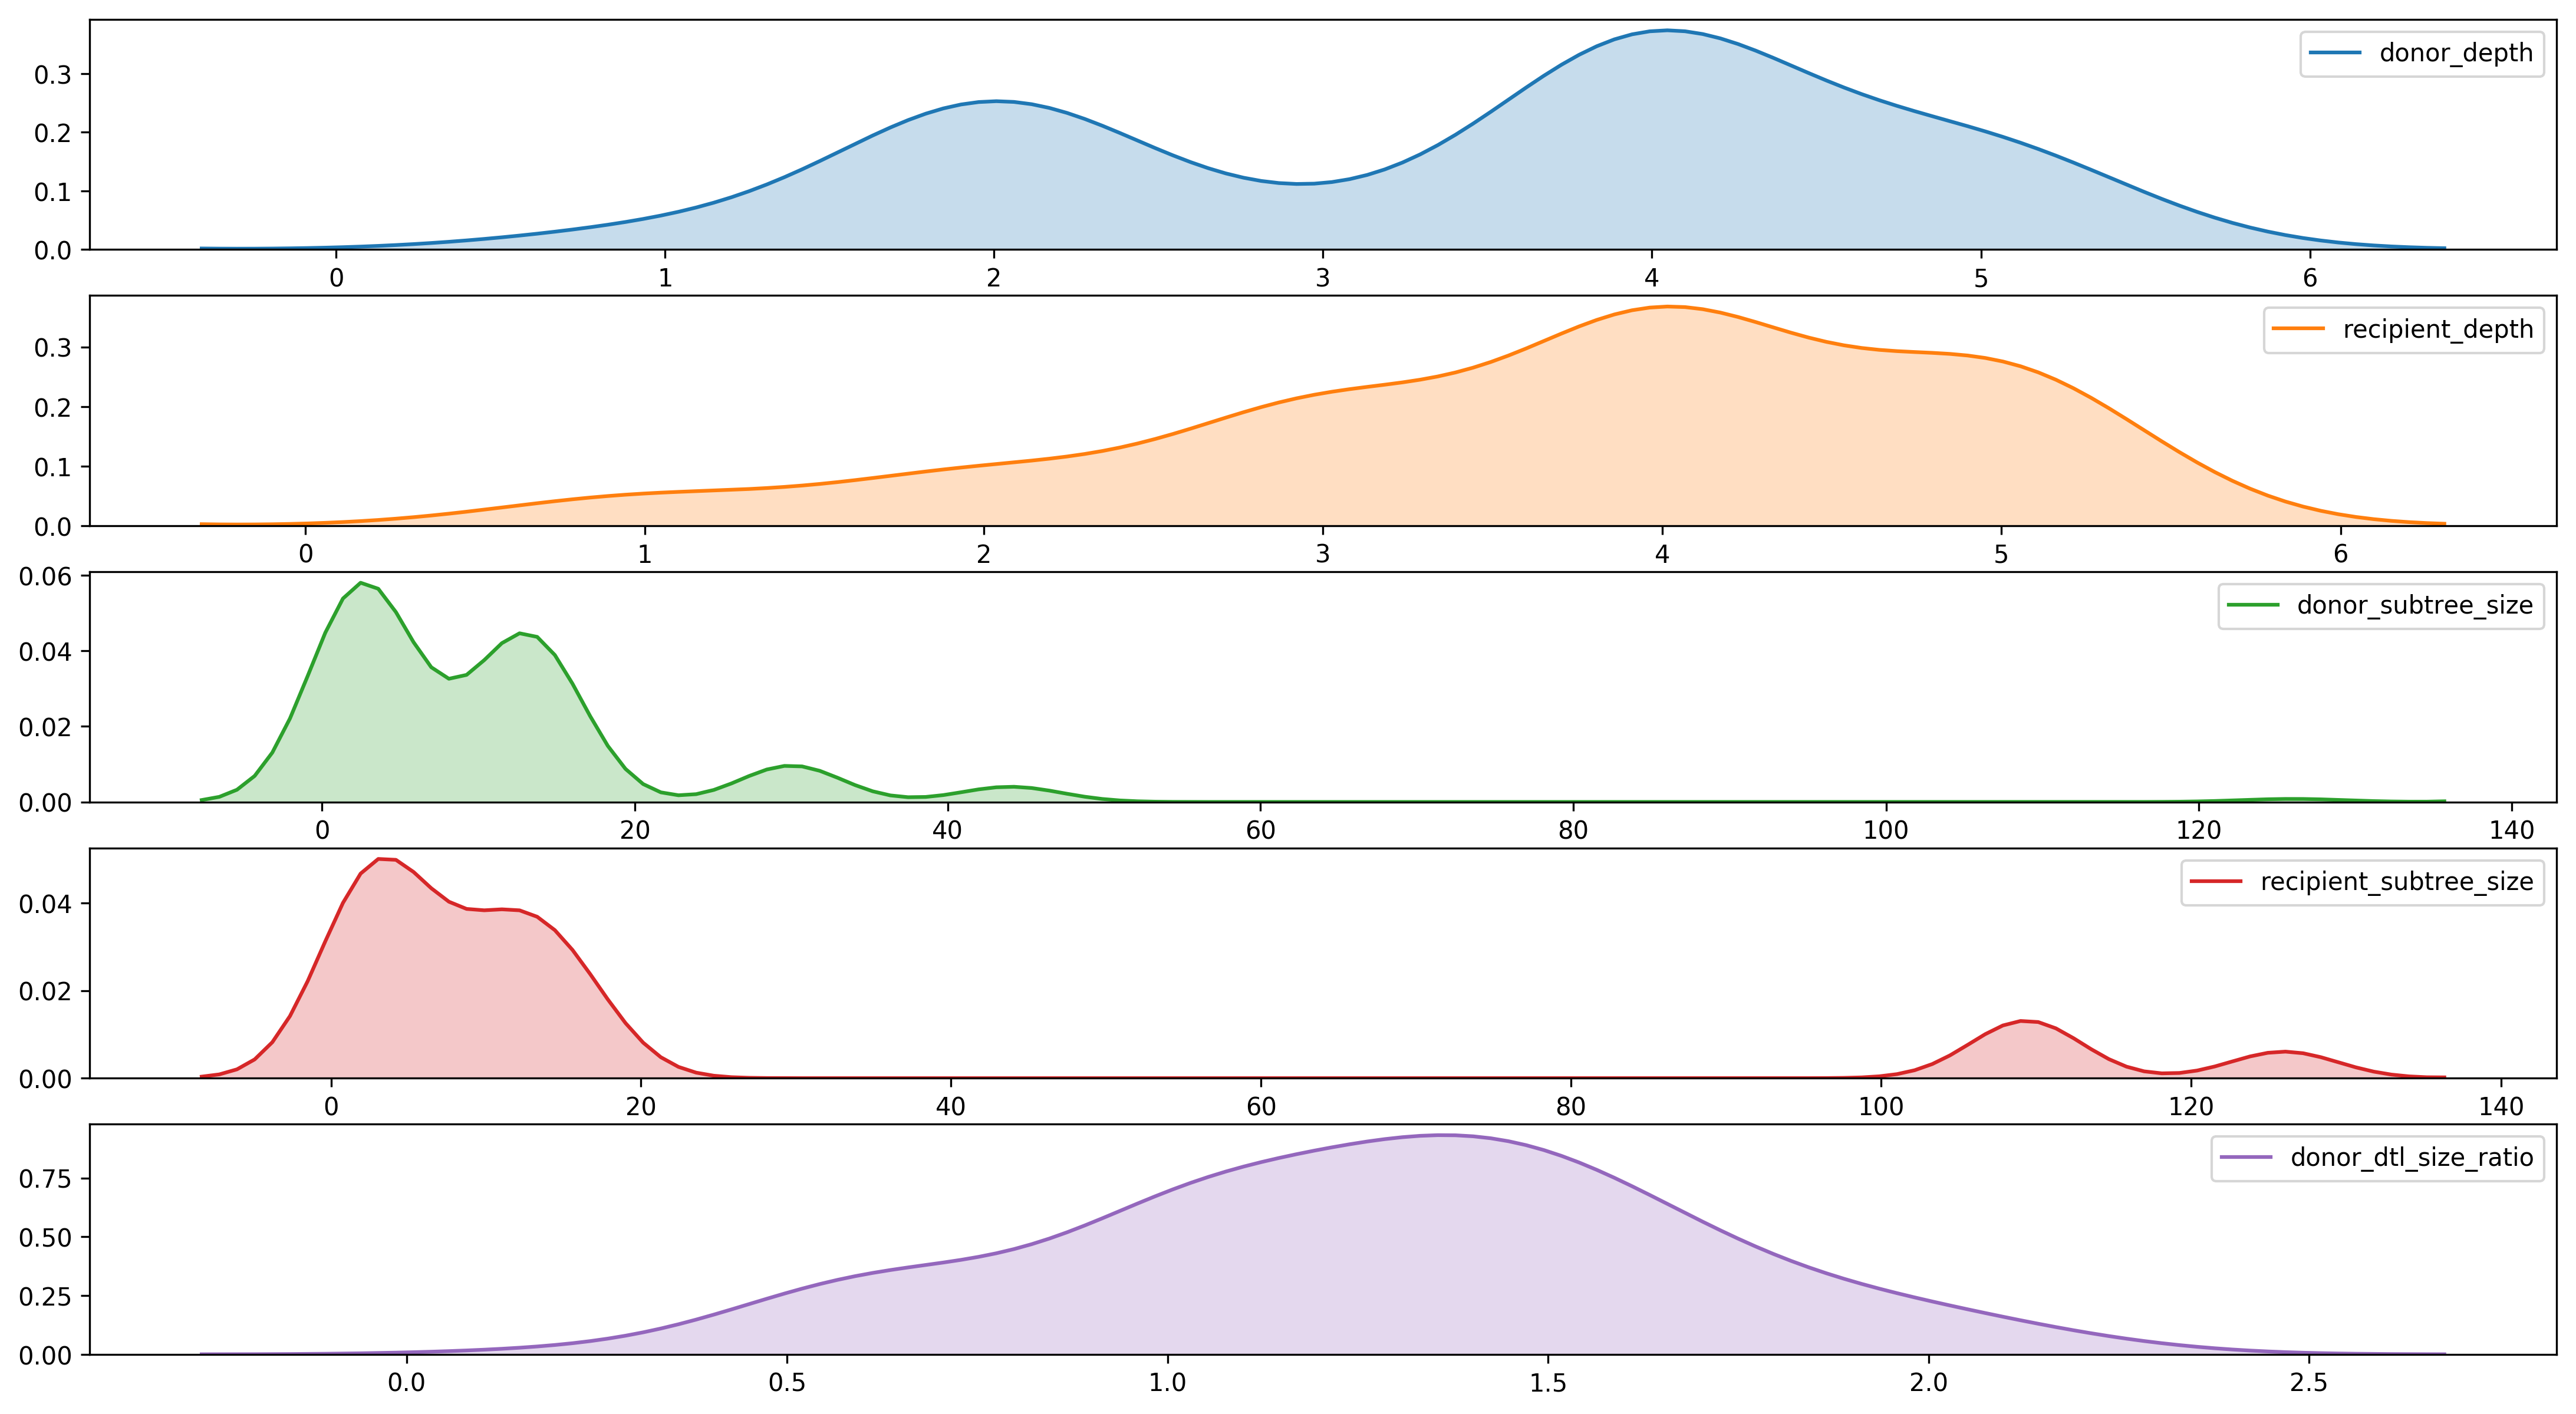

In [123]:
fig, axs = plt.subplots(nrows=5, figsize=(18,10), dpi=300)
colors   = sns.color_palette(n_colors=5).as_hex()
for row, column in enumerate(['donor_depth', 
                              'recipient_depth',
                              'donor_subtree_size',
                              'recipient_subtree_size',
                              'donor_dtl_size_ratio']):
    sns.kdeplot(extended_df.loc[(extended_df.donor_depth<=5)&(extended_df.recipient_depth<=5),
                                column],
                shade=True, color=colors[row], ax=axs[row])

In [336]:
extended_df = ranger_parser.map_taxonomic_level(extended_df, taxa_table='../genomes.tab')

In [340]:
extended_df

,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio,transfer_level
21,100.0,n76,m75,1.00,1.00,1.00,n79,m76,4468_BAB72593.1-GCA_000009705.1,0.372650,13.0,2.0,15.0,2.0,6.500000,7.500000,0.500000,phylum
33,95.0,n101,m83,1.00,1.00,1.00,n105,m91,6335_BAB74460.1-GCA_000009705.1,0.217616,16.0,4.0,16.0,6.0,4.000000,2.666667,1.222222,phylum
70,100.0,n76,m7,1.00,1.00,1.00,n108,m8,5056_BAB73181.1-GCA_000009705.1,0.454789,13.0,2.0,19.0,2.0,6.500000,9.500000,0.750000,phylum
128,96.0,n165,m326,1.00,1.00,1.00,n168,m330,1446_AAM72707.1-GCA_000006985.1,0.096659,8.0,2.0,10.0,2.0,4.000000,5.000000,0.500000,genus
151,99.0,n159,m11,1.00,1.00,1.00,n133,m12,8_AAM71256.1-GCA_000006985.1,1.031858,4.0,12.0,4.0,9.0,0.333333,0.444444,1.400000,superkingdom
154,99.0,n71,m35,1.00,1.00,1.00,n47,m36,11132_BAD79054.1-GCA_000010065.1,0.156922,11.0,4.0,8.0,3.0,2.750000,2.666667,1.461538,order
155,100.0,n71,m31,1.00,1.00,1.00,n79,m32,11132_BAD79054.1-GCA_000010065.1,0.326665,11.0,4.0,15.0,2.0,2.750000,7.500000,1.600000,phylum
203,100.0,n158,m2,1.00,1.00,1.00,n154,m3,1825_AAM73090.1-GCA_000006985.1,0.975459,4.0,2.0,8.0,2.0,2.000000,4.000000,1.500000,superkingdom
359,99.0,n76,m79,1.00,1.00,1.00,n79,m80,4043_AAQ00835.1-GCA_000007925.1,0.372650,13.0,2.0,15.0,2.0,6.500000,7.500000,0.500000,phylum
360,100.0,n82,m19,0.86,0.86,0.86,n98,m29,19225_BAC91897.1-GCA_000011385.1,0.382403,14.0,2.0,15.0,2.0,7.000000,7.500000,1.285714,phylum


In [341]:
phylum_transfers = extended_df.loc[extended_df.transfer_level == 'phylum']
kingdom_transfers = extended_df.loc[(extended_df.transfer_level == 'kingdom') |
                                    (extended_df.transfer_level == 'superkingdom')]

In [351]:
print(kingdom_transfers.shape)
kingdom_transfers.head()

(274, 18)


,bipartition_support,donor,donor_map,ranger_confidence,ranger_confidence_donor,ranger_confidence_recipient,recipient,recipient_map,family,donor_recipient_distance,donor_depth,donor_subtree_size,recipient_depth,recipient_subtree_size,donor_depth/size_ratio,recipient_depth/size_ratio,donor_dtl_size_ratio,transfer_level
151,99.0,n159,m11,1.0,1.0,1.0,n133,m12,8_AAM71256.1-GCA_000006985.1,1.031858,4.0,12.0,4.0,9.0,0.333333,0.444444,1.400000,superkingdom
203,100.0,n158,m2,1.0,1.0,1.0,n154,m3,1825_AAM73090.1-GCA_000006985.1,0.975459,4.0,2.0,8.0,2.0,2.000000,4.000000,1.500000,superkingdom
397,100.0,n159,m12,1.0,1.0,1.0,n153,m18,43158_ACI97772.1-GCA_000016185.1,0.932873,4.0,12.0,7.0,3.0,0.333333,2.333333,1.000000,superkingdom
402,100.0,n137,m4,1.0,1.0,1.0,n43,m5,7323_BAB75448.1-GCA_000009705.1,2.321203,7.0,2.0,11.0,2.0,3.500000,5.500000,1.851852,superkingdom
583,100.0,n142,m2,1.0,1.0,1.0,n135,m154,556_AAM71807.1-GCA_000006985.1,1.101958,3.0,16.0,6.0,4.0,0.187500,1.500000,1.764045,superkingdom


In [350]:
for group in kingdom_transfers.family.unique():
    os.system('cp gene_trees/%s.treefile.rooted genes_with_intra_kingdom_transfers/%s.tre' % (group, group.split('_')[0]))

In [530]:
ranger_parser.interactive_dynamic_plot(
    extended_df)

In [513]:
row = extended_df.loc[128]
extended_df.query('donor==@row.donor & recipient==@row.recipient').shape[0]

(20, 18)

In [531]:
plotly.__version__

'3.4.1'

In [529]:
%%add_to aggregate
def interactive_dynamic_plot(self, df):
    tracers = []
    max_x   = 0
    max_y   = 0
    rank_order = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'kingdom']
    rank_color = dict(zip(rank_order, np.linspace(0,1,15)[1::2]))
    rank_color['superkingdom'] = rank_color['kingdom']

    colors = cl.scales['9']['qual']['Paired']
    colorscale = []
    for pos, value in enumerate(np.linspace(0,1,8)):
        colorscale.append([value, colors[pos]])
        colorscale.append([value, colors[pos+1]])

    for group in df.family.unique():
        tracer = {'x':[], 'y':[], 'text':[], 'marker_color':[], 'marker_size':[]}
        group_number = int(group.split('_')[0])
        for index, row in df.query('family==@group').iterrows():
            corroborated_by = extended_df.query('donor==@row.donor & recipient==@row.recipient').shape[0]
            tracer['x'   ].append(row.donor_recipient_distance)
            tracer['y'   ].append(row['donor_depth/size_ratio'])
            tracer['text'].append('group_%i#%i' % (group_number, index))
            tracer['marker_size'].append(10+corroborated_by*2)
            tracer['marker_color'].append(rank_color[row.transfer_level]
                                          if pd.notnull(row.transfer_level) else 1)
    
        if np.max(tracer['x']) > max_x:
            max_x = np.max(tracer['x'])
        if np.max(tracer['y']) > max_y:
            max_y = np.max(tracer['y'])
        tracer = go.Scatter(x=tracer['x'],
                            y=tracer['y'],
                            mode='markers',
                            text=tracer['text'],
                            name='group_%s' % group.split('_')[0],
                            hoverinfo='text', showlegend=True,
                            marker=dict(size=tracer['marker_size'],
                                        color=tracer['marker_color'],
                                        colorscale=colorscale,
                                        cmax=1,
                                        cmin=0,
                                        symbol='circle',
                                        opacity=0.7)
                           )
        tracers.append(tracer)

    tracers = sorted(tracers, key = lambda x: int(x['name'].split('_')[1]))
    
    layout    = go.Layout(
        title='Interactive index HGT candidates plot!',
        hovermode='closest',
        width=1500, height=1000,
        xaxis=dict(title='Donor-Recipient distance', 
                   autorange=False, 
                   range=[0, max_x+max_x*0.01]),
        yaxis=dict(title='Donor depth/size ratio', 
                   autorange=False, 
                   range=[0, max_y+max_y*0.01]),
        updatemenus=[
            {'buttons':[{'label':'Show all',
                         'method':'restyle',
                         'args': [ 'visible', True]},
                        {'label':'Hide all',
                         'method':'restyle',
                         'args': [ 'visible', ['legendonly']*len(tracers)+[True]]}]}
        ]
    )
    
    tracers.append(go.Scatter(x=[max_x],
                             y=[max_y],
                             mode='markers',
                             name='colorbar',
                             showlegend=False,
                             marker=dict(size=10,
                                        color=0,
                                        symbol='circle',
                                        opacity=0.0,
                                        colorscale=colorscale,
                                        cmin=0,
                                        cmax=1,
                                        colorbar=dict(title='HGT within:',
                                                      x=1.25,
                                                      titleside = 'top',
                                                      tickvals = np.linspace(0,1,15)[1::2],
                                                      ticktext = rank_order,
                                                      ticks = 'outside')
                                        )
                           )
                  )
    
    fig       = go.Figure(data=tracers, layout=layout)
    plot      = plotly.offline.plot(fig, filename='./test.html', auto_open=False)

In [524]:
go.Layout.legend

AttributeError: 'property' object has no attribute 'item'

In [343]:
#ranger_parser.name_species_tree_nodes(
#    reconciliation_file='ranger/4468_BAB72593.1-GCA_000009705.1/4468_BAB72593.1-GCA_000009705.1.output1'
#)
ranger_parser.visualize_in_figtree(kingdom_transfers, taxa_table='../genomes.tab')